In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AISep, utils, Event, Simulation, root_files, DataModelSep
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# model name
model_name = 'model-lsr-sep'

shuffle_clusters = False

# load the training data
data = DataModelSep('data-mtx-enough-top-8.npz', 
                 batch_size = 128, validation_percent = .1, test_percent = .2, 
                 weight_compton=1.5, weight_non_compton=.5)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AISep(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
pos_conv_1 (Conv1D)             (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
enrg_conv_1 (Conv1D)            (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
typ_conv_1 (Conv1D)             (None, 8, 128)       1280        inputs[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.001)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 60:
        return .001
    elif epoch < 100:
        return .0003
    elif epoch < 140:
        return .0001
    elif epoch < 170:
        return .00003
    elif epoch < 190:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [5]:
# #LOADING
# ai.load(model_name, optimizer=False)
# ai.compile_model()

In [ ]:
#TRAINING

In [ ]:
%%time
#training type nn
ai.activate_type_training()
print()

# start the training
ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

In [ ]:
%%time
#training position nn
ai.activate_position_training()
print()

# start the training
ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

In [ ]:
%%time
#training energy nn
ai.activate_energy_training()
print()

# start the training
ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

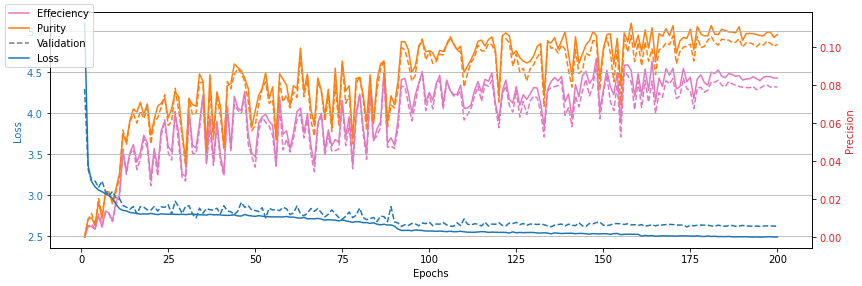

In [6]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [ ]:
# save the trained model
ai.save(file_name=model_name)